In [1]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

In [2]:
import cv2

def cxcywh2xyxy(x):
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2]/2  # x center
    y[..., 1] = x[..., 1] - x[..., 3]/2  # y center
    y[..., 2] = x[..., 0] + x[..., 2]/2  # width
    y[..., 3] = x[..., 1] + x[..., 3]/2  # height
    return y


def box_iou(box1, box2, eps=1e-7):
    """
    Calculate intersection-over-union (IoU) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Based on https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """

    (a1, a2), (b1, b2) = box1.unsqueeze(1).chunk(2, 2), box2.unsqueeze(0).chunk(2, 2)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp_(0).prod(2)

    # IoU = inter / (area1 + area2 - inter)
    return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)

In [3]:
class ConfusionMatrix:

    def __init__(self, nc, conf=0.25, iou_thres=0.45, task='detect'):
        """Initialize attributes for the YOLO model."""
        self.task = task
        self.matrix = np.zeros((nc + 1, nc + 1)) if self.task == 'detect' else np.zeros((nc, nc))
        self.nc = nc  # number of classes
        self.conf = conf
        self.iou_thres = iou_thres

    def process(self, detections, labels):

        #gt_classes = labels.int()
        #for gc in gt_classes:
        #    self.matrix[self.nc, gc] += 1  # background FN

        detections = detections[detections[:, 4] > self.conf]
        gt_classes = labels[:, 0].int()
        detection_classes = detections[:, 5].int()
        iou = box_iou(labels[:, 1:], detections[:, :4])

        x = torch.where(iou > self.iou_thres)
        if x[0].shape[0]:
            matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().numpy()
            if x[0].shape[0] > 1:
                matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
                matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
        else:
            matches = np.zeros((0, 3))

        n = matches.shape[0] > 0
        m0, m1, _ = matches.transpose().astype(int)
        for i, gc in enumerate(gt_classes):
            j = m0 == i
            if n and sum(j) == 1:
                self.matrix[detection_classes[m1[j]], gc] += 1  # correct
            else:
                self.matrix[self.nc, gc] += 1  # true background

        if n:
            for i, dc in enumerate(detection_classes):
                if not any(m1 == i):
                    self.matrix[dc, self.nc] += 1  # predicted background


    def plot(self, normalize=True, save_dir='', names=(), on_plot=None):

        array = self.matrix / ((self.matrix.sum(0).reshape(1, -1) + 1E-9) if normalize else 1)  # normalize columns
        array[array < 0.005] = np.nan  # don't annotate (would appear as 0.00)

        fig, ax = plt.subplots(1, 1, figsize=(12, 9), tight_layout=True)
        nc, nn = self.nc, len(names)  # number of classes, names
        sn.set(font_scale=1.0 if nc < 50 else 0.8)  # for label size
        labels = (0 < nn < 99) and (nn == nc)  # apply names to ticklabels
        ticklabels = (list(names) + ['background']) if labels else 'auto'
        sn.heatmap(array,
                       ax=ax,
                       annot=nc < 30,
                       annot_kws={
                           'size': 8},
                       cmap='Blues',
                       fmt='.2f' if normalize else '.0f',
                       square=True,
                       vmin=0.0,
                       xticklabels=ticklabels,
                       yticklabels=ticklabels).set_facecolor((1, 1, 1))
        title = 'Confusion Matrix' + ' Normalized' * normalize
        ax.set_xlabel('True')
        ax.set_ylabel('Predicted')
        ax.set_title(title)
        plt.show()

In [4]:
# matrix = ConfusionMatrix(nc=200)
# imagesPath = "*RPC/valid/images/*.png"
# labelsPath = "*RPC/valid/labels/*.txt"
# SupportPath = "RPC/support/images/"
# best = 'runs/oneshot/yolov8n_RPC/weights/best.pt'

matrix = ConfusionMatrix(nc=100)
imagesPath = "*COCO1/valid/images/*.png"
labelsPath = "*COCO1/valid/labels/*.txt"
SupportPath = "COCO1/support/images/"
best = 'runs/oneshot/yolov8n_COCO1__support0/weights/best.pt'

In [5]:
import glob
filesName =  glob.glob(imagesPath)
filesName.sort()
labelsName = glob.glob(labelsPath)
labelsName.sort()
print(len(filesName))
print(len(labelsName))

2477
2477


In [6]:
from ultralytics import YOLO
from PIL import Image

model = YOLO(best)  # load a pretrained YOLOv8n model

In [7]:
true_labels = {}
predictions = {}
# i = 0

for f,l in tqdm(zip(filesName[:1000],labelsName[:1000]), total=len(filesName[:1000])):
    name = f.split('.')[0]

    image = Image.open(f)
    image = np.asarray(image)
    support = Image.open(SupportPath+f.split('.')[1]+'.png')
    support = np.asarray(support)

    #convert GrayImage to RGB Image:
    if(len(image.shape) == 2):
        image = np.stack((image,)*3, axis=-1)

    results = model.predict(source=image, support=support, verbose=False)  # predict on an image

    bboxes = results[0].boxes.data.cpu().numpy()
    if bboxes.ndim == 1:
        bboxes = np.array([bboxes])
    bboxes[:,5] = int(f.split('.')[1])
    bboxes[:,:4] = bboxes[:,:4]/results[0].orig_img.shape[0]

    label = np.loadtxt(l)
    if label.ndim == 1:
        label = np.array([label])
    label[:,0] = int(f.split('.')[1])

    #bboxes[:,0:4] = xyxy2xywh(bboxes[:,0:4])
    label[:,1:5] = cxcywh2xyxy(label[:,1:5])

    if name not in true_labels.keys():
        predictions[name] = bboxes
        true_labels[name] = label
    else:
        if len(bboxes) != 0:
            predictions[name] = np.concatenate((predictions[name],bboxes),0)
        true_labels[name] = np.concatenate((true_labels[name],label),0)

    # i = i + 1
    # if(i >= 200):
    #     break

100%|██████████| 1000/1000 [01:00<00:00, 16.61it/s]


In [8]:
for t,p in tqdm(zip(true_labels.values(),predictions.values()), total=len(true_labels)):
    matrix.process(torch.asarray(p),torch.asarray(t))

 31%|███       | 250/810 [00:00<00:00, 2498.75it/s]

100%|██████████| 810/810 [00:00<00:00, 2643.93it/s]


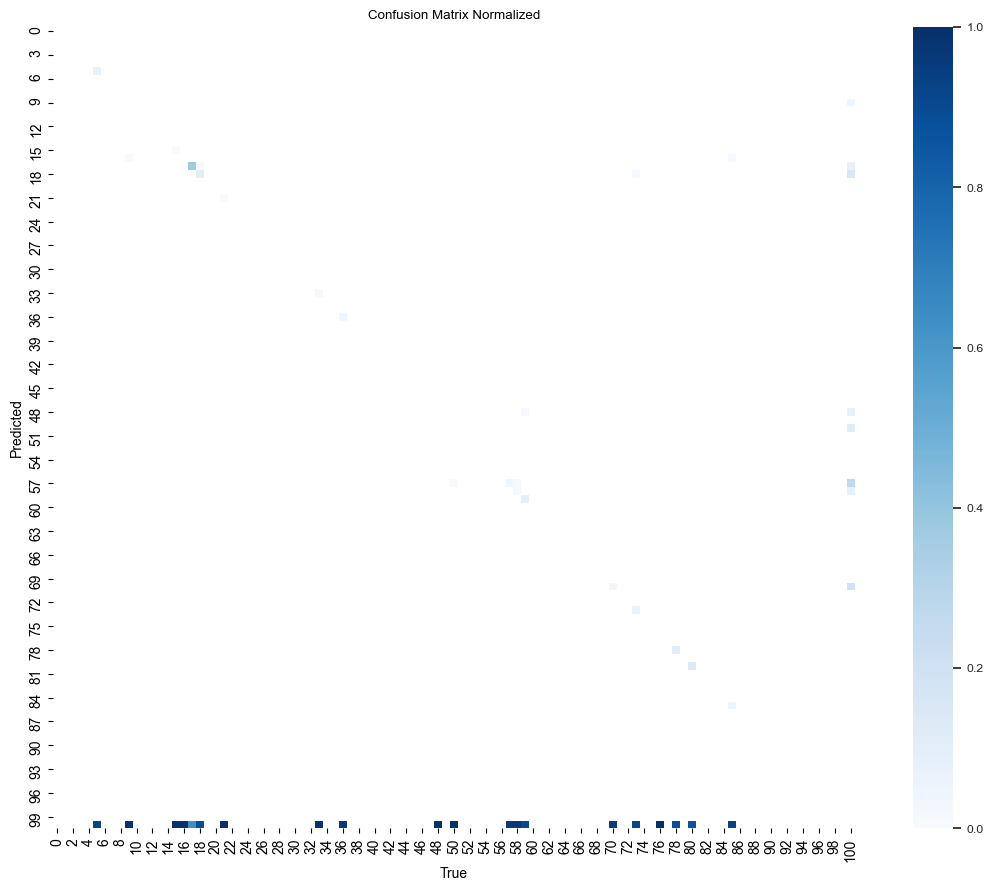

In [9]:
matrix.plot()

In [10]:
def plot(t,p, image):
    img = np.copy(image)
    bbox = t[:,1:5]*640
    # Blue color in BGR
    color = (255, 0, 0)
  
    # Line thickness of 2 px
    thickness = 2   
    for x1,y1,x2,y2 in bbox:
        cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), color, thickness)

    bbox = p[:,:4]*640
    # Green color in BGR
    color = (0, 255, 0)
  
    # Line thickness of 2 px
    thickness = 2   
    for x1,y1,x2,y2 in bbox:
        cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), color, thickness)

    plt.figure()
    plt.imshow(img)

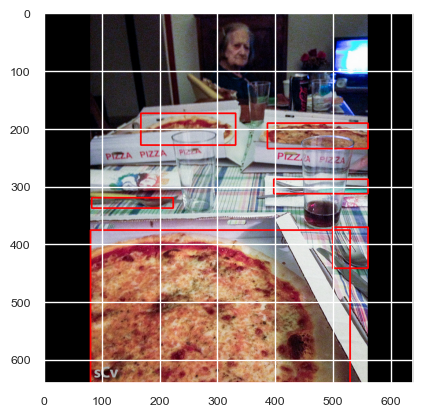

In [19]:
f = filesName[50]

name = f.split('.')[0]
image = Image.open(f)
t = true_labels[name]
p = predictions[name] 
plot(t,p, image)